# KernelRidge Experiment with data

In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score ,classification_report
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Parameters

In [2]:
split = True
fine_tune = True
sklearn = False
logistic = True
visualization = True
Submission = False

In [3]:
def rbf_kernel(X1, X2, sigma=None):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    if sigma is None:
            sigma = sigma_from_median(X)
    # For loop with rbf_kernel_element works but is slow in python
    # Use matrix operations!
    X2_norm = np.sum(X2 ** 2, axis=-1)
    X1_norm = np.sum(X1 ** 2, axis=-1)
    gamma = 1 / (2 * sigma ** 2)
    K = np.exp(- gamma * (X1_norm[:, None] + X2_norm[None, :] - 2 * np.dot(X1, X2.T)))
    return K

def linear_kernel(X1, X2):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the linear kernel
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    return X1.dot(X2.T)

def polynomial_kernel(X1, X2, degree=3):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the polynomial kernel of degree `degree`
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    degree: int
    '''
    return (1 + linear_kernel(X1, X2))**degree

In [4]:
def sigma_from_median(X):
    '''
    Returns the median of ||Xi-Xj||
    
    Input
    -----
    X: (n, p) matrix
    '''
    pairwise_diff = X[:, :, None] - X[:, :, None].T
    pairwise_diff *= pairwise_diff
    euclidean_dist = np.sqrt(pairwise_diff.sum(axis=1))
    return np.median(euclidean_dist)


In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class KernelLogisticRegression():
    '''
    Kernel Logistic Regression
    
    Methods
    ----
    fit
    predict
    '''
    kernels_ = {
        'linear': linear_kernel,
        'polynomial': polynomial_kernel,
        'rbf': rbf_kernel,
        # 'custom_kernel': custom_kernel, # Your kernel
    }
    def __init__(self, lambd=0.1, kernel='linear', **kwargs):
        self.lambd = lambd
        self.kernel_name = kernel
        self.kernel_function_ = self.kernels_[kernel]
        self.kernel_parameters = self.get_kernel_parameters(**kwargs)
        
        
    def get_kernel_parameters(self, **kwargs):
        params = {}
        if self.kernel_name == 'rbf':
            params['sigma'] = None
        if self.kernel_name == 'polynomial':
            params['degree'] = kwargs.get('degree', 2)
        # if self.kernel_name == 'custom_kernel':
        #     params['parameter_1'] = kwargs.get('parameter_1', None)
        #     params['parameter_2'] = kwargs.get('parameter_2', None)
        return params

    def WKRR(self, K, y, sample_weights=None):
        '''
        Weighted Kernel Ridge Regression

        This is just used for the KernelLogistic following up
        '''

        self.y_train = y
        n = len(self.y_train)

        w = np.ones_like(self.y_train) if sample_weights is None else sample_weights
        W = np.diagflat(np.sqrt(w))

        A = W.dot(K).dot(W)
        A[np.diag_indices_from(A)] += self.lambd * n
        # self.alpha = W (K + n lambda I)^-1 W y
        return W.dot(np.linalg.solve(A , W.dot(self.y_train)))

    def fit(self, X, y, max_iter=100, tol=1e-5):
    
        self.X_train = X
        self.y_train = y
        
        K = self.kernel_function_(X, X, **self.kernel_parameters)
        
        

        # Initialize
        alpha = np.zeros_like(self.y_train)
        # Iterate until convergence or max iterations
        for n_iter in range(max_iter):
            alpha_old = alpha
            f = K.dot(alpha_old)
            w = sigmoid(f) * sigmoid(-f)
            z = f + y / sigmoid(-y*f)
            # IRLS
            alpha = self.WKRR(K, z, sample_weights=w)
            # Break condition (achieved convergence)
            if np.sum((alpha-alpha_old)**2) < tol:
                break
        self.n_iter = n_iter
        self.alpha = alpha

        return self
            
        
    def decision_function(self, X):
        K_x = self.kernel_function_(X, self.X_train, **self.kernel_parameters)    
        return K_x

    def predict(self, X):
        return np.sign(self.decision_function(X) @ self.alpha)

# My data

In [6]:
X_train = pd.read_csv('Xtr_vectors.csv')
X_train.drop('Id', inplace=True, axis=1)
y_train = pd.read_csv('Ytr.csv')
y_train.drop('Id', inplace=True, axis=1)
X_test = pd.read_csv('Xte_vectors.csv')
iD = pd.DataFrame(X_test.Id)
X_test.drop('Id', inplace=True, axis=1)

In [7]:
X = np.array(X_train)

y = np.array(y_train)
Xt = np.array(X_test)

if (logistic and split):
    y = 2*y - 1
if split:
    
    X, Xt, y, yt = train_test_split(X, y, test_size=0.33, random_state=42)
    
## Scaling is important!
sc = StandardScaler().fit(X)
X = sc.transform(X)
Xt = sc.transform(Xt)
X.shape

(1340, 64)

In [8]:
y.shape

(1340, 1)

# Fine-Tuning

In [9]:
best_C = 0.015998587196060583
C = 10**np.linspace(0,3,50)
score = 0

if (sklearn and (split and fine_tune)):
    for i in C:

        # Create the model
        clf1 = LinearSVC(penalty='l2', loss='hinge', C=i)
        # Train the model
        clf1.fit(X, y)

        # Training error
        y_fit1 = clf1.predict(X)
        err_train = accuracy(y_fit1, y)

        # Testing error
        y_fit2 = clf1.predict(Xt)
        err_test = accuracy(y_fit2, yt)
        print('C : ',i,' Accuracy : ',err_test)

        acc = accuracy(y_fit2, yt)
        if (score < acc):
            best_C = i
            score = acc
    print('the best C is : ',best_C,' acc : ',score)


In [10]:
#if kernel= 'polynomial' enable best_lambd = 27. lam = range(2,37)
# if kernel = 'rbf' lam = 10**np.linspace(-2,5,50) enable best_lambd = 5.
#if kernel= 'linear' enable best_lambd = 4. lam = range(2,37)
best_lambd = 27.
kernel = 'polynomial'
degree = 5
sigma = None
if fine_tune: 
    lam = range(2,37)
    score = 0
    for i in lam: 
        model = KernelLogisticRegression(lambd=i, kernel=kernel, sigma=sigma, degree=degree)
        y_pred = model.fit(X, y).predict(Xt)
        acc = accuracy_score(y_pred, yt)
        print('lambda : ',i,' Accuracy : ',acc)
        if (score < acc):
            best_lambd = i
            score = acc
    print('the best lambda is : ',best_lambd,' acc : ',score)


lambda :  2  Accuracy :  0.9363636363636364
lambda :  3  Accuracy :  0.9363636363636364
lambda :  4  Accuracy :  0.9363636363636364
lambda :  5  Accuracy :  0.9363636363636364
lambda :  6  Accuracy :  0.9363636363636364
lambda :  7  Accuracy :  0.9363636363636364
lambda :  8  Accuracy :  0.9363636363636364
lambda :  9  Accuracy :  0.9363636363636364
lambda :  10  Accuracy :  0.9363636363636364
lambda :  11  Accuracy :  0.9363636363636364
lambda :  12  Accuracy :  0.9363636363636364
lambda :  13  Accuracy :  0.9363636363636364
lambda :  14  Accuracy :  0.9363636363636364
lambda :  15  Accuracy :  0.9363636363636364
lambda :  16  Accuracy :  0.9363636363636364
lambda :  17  Accuracy :  0.9363636363636364
lambda :  18  Accuracy :  0.9363636363636364
lambda :  19  Accuracy :  0.9363636363636364
lambda :  20  Accuracy :  0.9363636363636364
lambda :  21  Accuracy :  0.9363636363636364
lambda :  22  Accuracy :  0.9363636363636364
lambda :  23  Accuracy :  0.9363636363636364
lambda :  24  Accu

# Training

## With sklearn

In [11]:
if sklearn:
    # Create the model
    clf1 = LinearSVC(penalty='l2', loss='hinge', C=best_C)
    # Train the model
    clf1.fit(X, y)

    # Training error
    y_fit1 = clf1.predict(X)
    err_train = ((y != y_fit1)*1).sum()/len(y)

## Our Model

In [12]:
# Parameters already specified in the tune function
model = KernelLogisticRegression(lambd=best_lambd, kernel=kernel, sigma=sigma, degree=degree)
y_pred = model.fit(X, y).predict(Xt)
print('Test error: {:.2%}'.format(accuracy_score(yt,y_pred)))

Test error: 93.64%


# Metric

In [13]:
if split:
    print("Our model's performance:")
    print('Accuracy: {:.2%}'.format(accuracy_score(yt, y_pred)))
    print('AUC: {:.2%}'.format(roc_auc_score(yt, y_pred)))
    print('error: {:.2%}'.format(((yt != y_pred)*1).sum()/len(yt)))    
    print(classification_report(yt, y_pred))

Our model's performance:
Accuracy: 93.64%
AUC: 93.84%
error: 6.36%
              precision    recall  f1-score   support

          -1       0.99      0.89      0.94       343
           1       0.89      0.99      0.94       317

    accuracy                           0.94       660
   macro avg       0.94      0.94      0.94       660
weighted avg       0.94      0.94      0.94       660



# Visualization

In [14]:
# Visualization
# References: https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(classifier, xx, yy, add_intercept=False, **params):
    """Plot the decision boundaries for a classifier.
    
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    X = np.c_[xx.ravel(), yy.ravel()]
    if add_intercept:
        X = add_column_ones(X)
    Z = classifier.predict(X)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def plot_decision_function(classifier, X_train, y_train, title='', add_intercept=False):
    fig = plt.figure(figsize=(8,7))
    X0, X1 = X_train[:, 0], X_train[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(classifier, xx, yy, cmap=plt.cm.GnBu, alpha=0.5, add_intercept=add_intercept)
    plt.scatter(X0, X1, c=y_train, cmap=plt.cm.GnBu, s=20, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    plt.show()

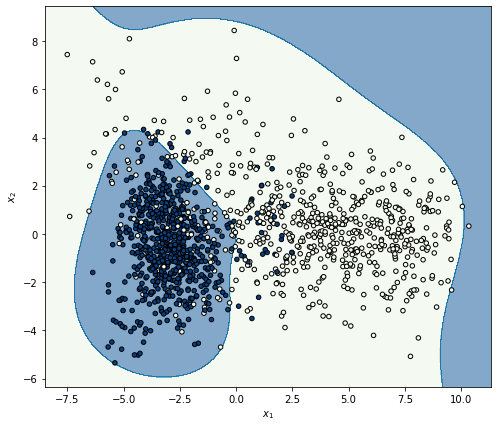

In [15]:
# Parameters already specified in the tune function
if visualization:
    pca = PCA(n_components = 2)
    X_pca = pca.fit_transform(X)
    clf = KernelLogisticRegression(lambd=best_lambd, kernel=kernel, sigma=sigma, degree=degree)
    clf.fit(X_pca, y)
    plot_decision_function(clf, X_pca, y, title='', add_intercept=False)

# Submission

In [16]:
if (not split and submission):
    #data frame for prediction
    pred = pd.DataFrame(y_pred, columns = ["Covid"])
    #stack the data frame for id and pred
    result = pd.DataFrame(np.hstack([iD,pred]), columns = ["ID", "Covid"])
    result.to_csv("Yte.csv",index=False)